# PyFiberAmp usage examples

In [1]:
# Some required imports
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] =(12,10)

## Example 1: 17 dB double-clad Yb-doped fiber amplifier

This example reproduces some of the results in [1], whose authors used the commercial RP Fiber Power software to model a double-clad fiber amplifier. The initial parameters should define an amplifier with 17 dB gain. 

In [2]:
from pyfiberamp import FiberAmplifierSimulation
from pyfiberamp.fibers import YbDopedDoubleCladFiber

In [3]:
# The fiber parameters
length = 3
core_radius = 5e-6
pump_cladding_radius = 50e-6
ratio_of_core_and_cladding_diameters = core_radius / pump_cladding_radius
core_na = 0.12 # This does not play a role since we define the mode field diameter later
yb_number_density = 3e25
background_loss = 0

In [4]:
# Create the fiber
dc_fiber = YbDopedDoubleCladFiber(length=length,
                               core_radius=core_radius,
                               ratio_of_core_and_cladding_diameters=ratio_of_core_and_cladding_diameters,
                               core_na=core_na,
                               ion_number_density=yb_number_density,
                               background_loss=background_loss)

In [5]:
# Create the simulation and add signal and pump channels
simulation = FiberAmplifierSimulation(dc_fiber)
simulation.add_cw_signal(wl=1030e-9, power=0.4, mode_field_diameter=9.6e-6)
simulation.add_backward_pump(wl=914e-9, power=47.2)

In [6]:
# Run the simulation
result = simulation.run()
assert(result.success())

   Iteration    Max residual    Total nodes    Nodes added  
       1          3.00e-04          20              0       
Solved in 1 iterations, number of nodes 20, maximum relative residual 3.00e-04.


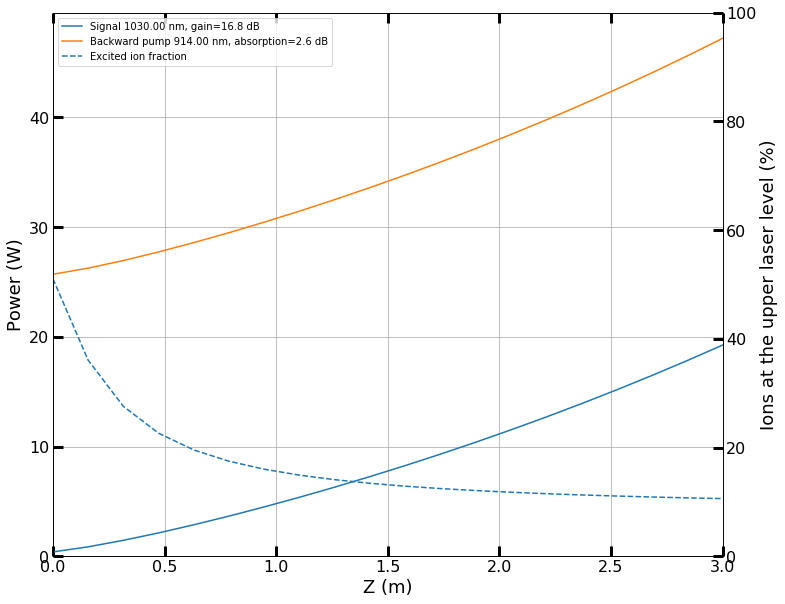

In [7]:
# Plotting the steady state
result.plot_power_evolution()

The authors of ref [1] obtained a signal gain of 17 dB from their simulation. The 16.8 dB gain predicted by PyFiberAmp is very close considering that they probably used slightly different values for the absorption and emission cross sections.

## Example 2: Raman generation in passive fiber

This example demonstrates stimulated Raman scattering in a long passive optical fiber at 1550 nm. The numbers are taken from Agrawal's Nonlinear Fiber Optics (4th edition) pages 278-279 [2]. The approximate formula for Raman threshold predicts that signal and Raman powers should be equal at the fiber output with the given initial parameters.

In [8]:
from pyfiberamp.fibers import PassiveFiber
from pyfiberamp import FiberAmplifierSimulationWithRaman, decibel_to_exp

In [9]:
# The fiber parameters
length = 20e3
effective_area = 50e-12
core_radius = np.sqrt(effective_area / np.pi)
background_loss_dB = 0.0002
core_na = 0.12 # does not play a role but some value is required

In [10]:
# Create the fiber
raman_fiber = PassiveFiber(length=length,
                           core_radius=core_radius,
                           core_na=core_na,
                           background_loss = decibel_to_exp(background_loss_dB))
raman_fiber.effective_area_type = 'core_area' # This makes sure that we are using the correct effective area 50 um^2

In [11]:
# Create the simulation and optical channels
raman_simulation = FiberAmplifierSimulationWithRaman(raman_fiber)
raman_simulation.add_cw_signal(wl=1550e-9, power=0.6)
raman_simulation.add_raman(backward_raman_allowed=False)

In [12]:
# Run the simulation. Raman simulation typically requires a tighter tolerance to obtain the correct result.
# With tol=1e-5, the Raman output power would be just 0.087 W
raman_result = raman_simulation.run(tol=1e-6)
assert(raman_result.success())

   Iteration    Max residual    Total nodes    Nodes added  
       1          1.21e-03          20             10       
       2          1.33e-05          30              4       
       3          5.51e-09          34              0       
Solved in 3 iterations, number of nodes 34, maximum relative residual 5.51e-09.


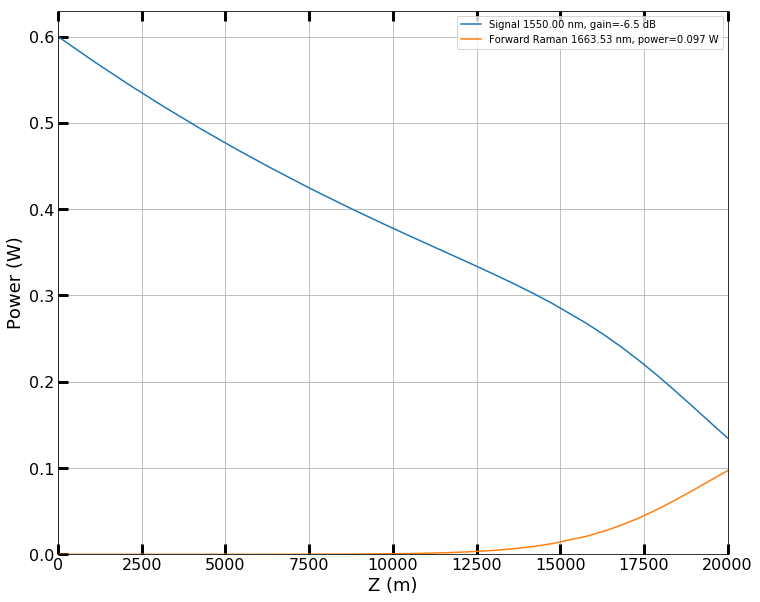

In [13]:
#Plotting the steady state power evolution
raman_result.plot_power_evolution()

The signal and Raman powers are almost equal, so the agreement with the approximation for Raman threshold is good.

## Example 3: Parameter sweep

This example uses the same design as example 1. This time we vary the pump wavelength and record how the signal gain for each pump wavelength.

In [14]:
# Parameters
pump_wavelengths = np.linspace(890, 1030, 101) * 1e-9
simulated_gains = []
result = None

In [15]:
# Running the simulation with different pump wavelengths
for pump_wl in pump_wavelengths:
    # The simulation has to be initialized again even though only one parameter changes
    simulation = FiberAmplifierSimulation(dc_fiber)
    simulation.solver_verbosity = 0
    simulation.add_cw_signal(wl=1030e-9, power=0.4, mode_field_diameter=2 * 4.8e-6)
    simulation.add_backward_pump(wl=pump_wl, power=47.2)
    
    # Starting from the 2nd simulation, we can use the result of the previous simulation as
    # the initial guess for the next simulation to speed up the calculation.
    if result is not None:
        simulation.set_guess_array(result.P)
    
    # The simulation is run and the gain is stored in a list
    result = simulation.run(tol=1e-5)
    result_dict = result.make_result_dict()
    signal_gain = result_dict['forward_signal']['gain'][0]
    simulated_gains.append(signal_gain)

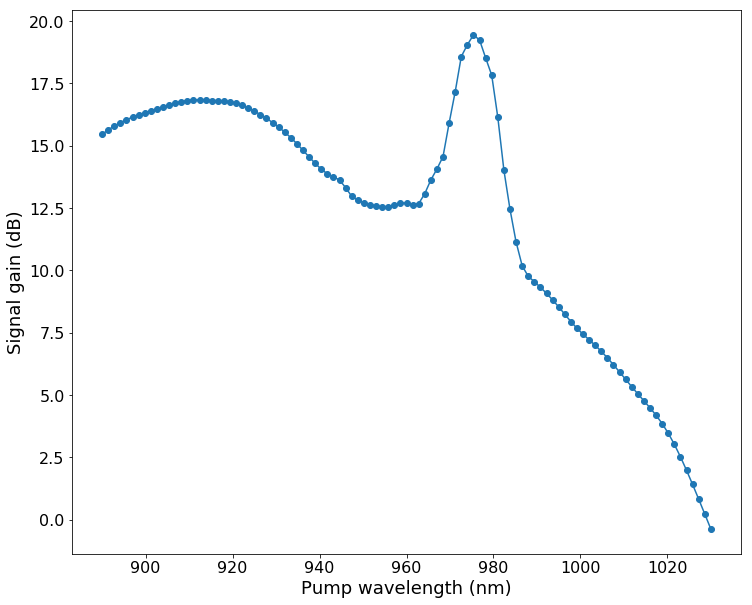

In [16]:
# Plotting the gain vs. pump wavelength
plt.plot(pump_wavelengths * 1e9, simulated_gains, '-o')
plt.xlabel('Pump wavelength (nm)', fontsize=18)
plt.ylabel('Signal gain (dB)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

The result looks realistic, showing a broad peak around 915 nm and a sharper peak at 976 nm. As the pump wavelength approaches the signal wavelength 1030 nm, the gain goes to zero. The small "jumps" are caused by the roughness of the cross section data.

## References

[1] Albalawi, A., Zhu, H., Taccheo, S. et al. Opt Quant Electron (2016) 48: 500. https://doi.org/10.1007/s11082-016-0771-z

[2] Govind P. Agrawal, Chapter 8 - Stimulated Raman Scattering, In Optics and Photonics, Academic Press, San Diego, 2006, Pages 278-279, ISSN 15575837, Nonlinear Fiber Optics (Fourth Edition), ISBN 9780123695161